In [55]:
# !pip install -qq diffusers transformers ftfy accelerate


In [160]:
import os
import torch
import math

import PIL
from PIL import Image

from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

In [202]:
import importlib
def reload_module(module_name):
  module = importlib.import_module(module_name)
  importlib.reload(module)

In [203]:
import assignment24Helper as ah
reload_module("assignment24Helper")

In [199]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
# "runwayml/stable-diffusion-v1-5"
PRE_TRAINED_MODEL = "runwayml/stable-diffusion-v1-5"
print(torch_device)

cuda


In [204]:
torch.manual_seed(ah.Config.SEED)
generator = torch.Generator(device="cuda").manual_seed(ah.Config.SEED)

In [201]:
def image_grid(imgs, rows=1, cols=None):
    if cols is None: cols = math.ceil(len(imgs)/rows)
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [166]:
concept_libraries = [
    "sd-concepts-library/birb-style",
    "sd-concepts-library/line-art",
    "sd-concepts-library/poolrooms",
    "sd-concepts-library/midjourney-style",
    "sd-concepts-library/depthmap"
]

    # "sd-concepts-library/glow-forest",    
    # "sd-concepts-library/style-of-marc-allante",
    # "sd-concepts-library/3d-female-cyborgs",
    # "sd-concepts-library/malika-favre-art-style",
    # "sd-concepts-library/dan-mumford"    


In [167]:
prompt = "A cinematic hand made wall poster of girl with umbrella and red flower"
num_samples = 2 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

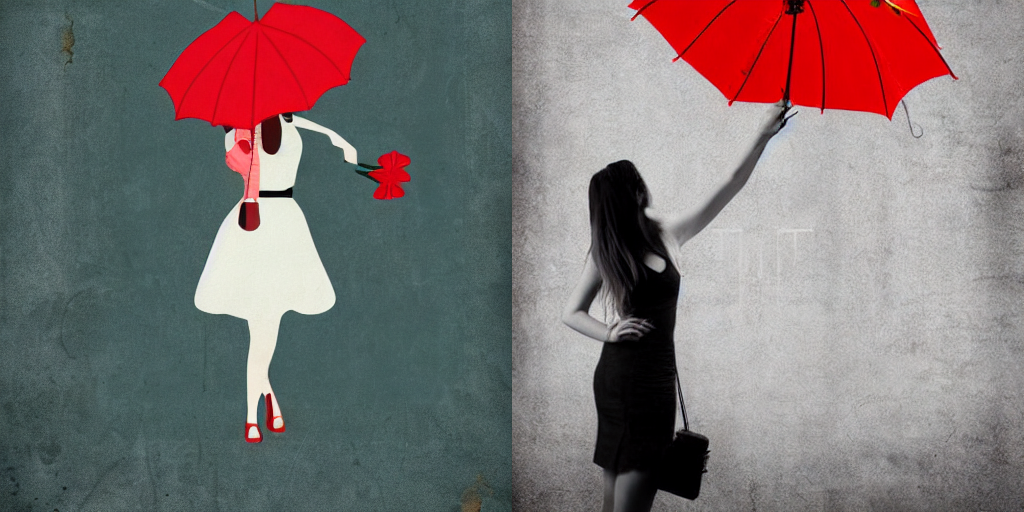

In [140]:
all_images = [] 
pipe = ah.get_stable_diffusion_pipeline(PRE_TRAINED_MODEL, torch_device=torch_device)

for _ in range(num_rows):
    images = pipe(prompt,
                  num_images_per_prompt=num_samples,
                  num_inference_steps=ah.Config.INFERENCE_STEPS,
                  guidance_scale=ah.Config.GUIDANCE_SCALE,
                  generator=generator).images
    all_images.extend(images)

grid = image_grid(all_images, rows=1)
grid

In [127]:
prompt_template = "A cinematic hand made wall poster of girl with umbrella and red <TBD>"

In [143]:
all_images = [] 
i = 1
pipe = ah.get_stable_diffusion_pipeline(PRE_TRAINED_MODEL, torch_device=torch_device)
for library in concept_libraries:
    generator = torch.Generator(device="cuda").manual_seed(ah.Config.SEED * i)
    i = i + 1
    
    # pipe.load_textual_inversion("sd-concepts-library/cat-toy")
    replacement_prompt_word = library.split("/")[1]
    prompt = prompt_template.replace("TBD", replacement_prompt_word)
    pipe.load_textual_inversion(library)
    print(prompt)
    for _ in range(num_rows):
        images = pipe(prompt, num_images_per_prompt=num_samples,
                        num_inference_steps=ah.Config.INFERENCE_STEPS,
                        guidance_scale=ah.Config.GUIDANCE_SCALE,
                        generator=generator).images
        all_images.extend(images)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


A cinematic hand made wall poster of girl with umbrella and red <birb-style>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made wall poster of girl with umbrella and red <line-art>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made wall poster of girl with umbrella and red <poolrooms>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made wall poster of girl with umbrella and red <midjourney-style>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made wall poster of girl with umbrella and red <depthmap>


  0%|          | 0/50 [00:00<?, ?it/s]

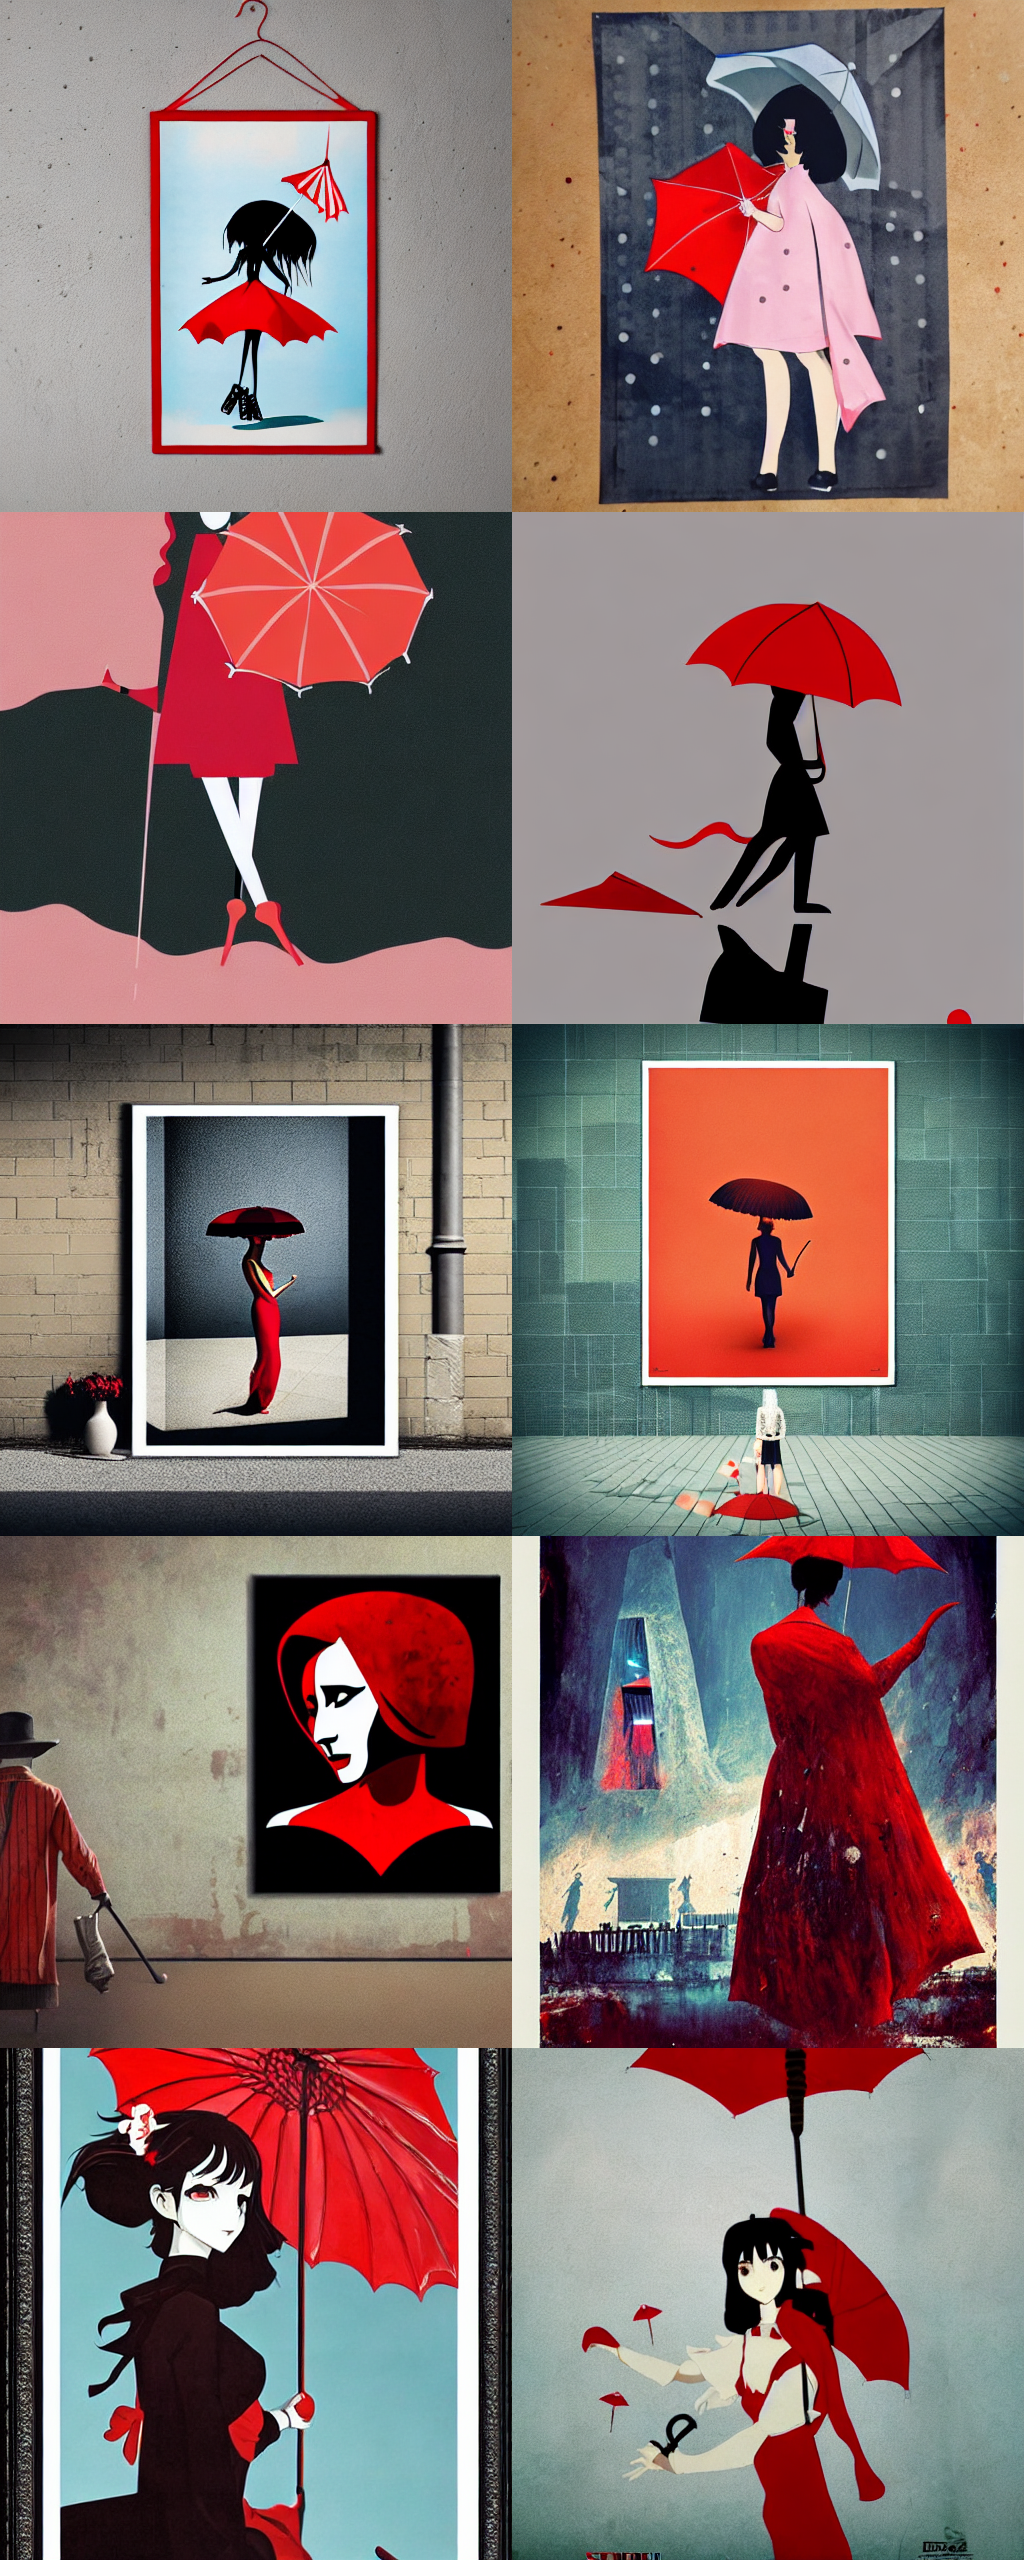

In [144]:
grid = image_grid(all_images, rows=len(concept_libraries))
grid

In [67]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# image_arrays = [np.array(img) for img in all_images]
# fig, axes = plt.subplots(nrows=10, figsize=(20, 100))
# for ax, img in zip(axes, image_arrays):
#     ax.imshow(img)
#     ax.axis('off')
# plt.show()

# Diffusion based on downloaded embeddings

In [168]:
from tqdm.auto import tqdm

In [205]:
models = ah.DiffuserModels(model_name=PRE_TRAINED_MODEL, torch_device=torch_device)

In [206]:
prompt = 'flower'
tokens = models.tokenizer(prompt)
print('tokenizer(prompt):', tokens)

SELECTED_TOKEN = tokens["input_ids"][1]
print(SELECTED_TOKEN)

tokenizer(prompt): {'input_ids': [49406, 4055, 49407], 'attention_mask': [1, 1, 1]}
4055


In [207]:
pos_emb_layer = models.text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [208]:
token_emb_layer = models.text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

In [209]:
position_ids = models.text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)

torch.Size([1, 77, 768])


In [210]:
prompt = "A cinematic hand made wall poster of girl with umbrella and red flower"
text_input = models.tokenizer(prompt, padding="max_length",
                              max_length=models.tokenizer.model_max_length,
                              truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)
token_embeddings = token_emb_layer(input_ids)
# Only printing first 20 tokens
print('tokenizer(prompt):', input_ids[0][:20], input_ids[0].shape)
## Flower token = 4055

tokenizer(prompt): tensor([49406,   320, 25602,  2463,  1105,  2569,  3574,   539,  1611,   593,
        17143,   537,   736,  4055, 49407, 49407, 49407, 49407, 49407, 49407],
       device='cuda:0') torch.Size([77])


In [211]:
i = 1
embedding_directory = "embeddings"
all_images = [] 
for library in concept_libraries:

    # Here generator is set for CPU

    generator = torch.Generator(device="cpu").manual_seed(ah.Config.SEED * i)
    i = i + 1

    # pipe.load_textual_inversion("sd-concepts-library/cat-toy")
    replacement_prompt_word = library.split("/")[1]

    embeddings = torch.load(os.path.join(os.getcwd(), embedding_directory, replacement_prompt_word + "-learned_embeds.bin"))
    
    print(list(embeddings.keys()) ,len(embeddings[list(embeddings.keys())[0]]))
    replacement_token_embedding = embeddings[list(embeddings.keys())[0]].to(torch_device)
    token_embeddings[0, torch.where(input_ids[0]==SELECTED_TOKEN)] = replacement_token_embedding.to(torch_device)
    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings
    #  Feed through to get final output embs
    modified_output_embeddings = ah.get_output_embeds(models=models, input_embeddings= input_embeddings)
    latents = ah.generate_with_embs(models=models, text_embeddings= modified_output_embeddings,
                                     generator=generator,
                                     text_input_max_length=text_input.input_ids.shape[-1])

    print(latents.shape)
    all_images.append(ah.latents_to_pil(latents, models.vae)[0])
    break


['<birb-style>'] 768


c:\Users\1430647\My\repo\github\assignment-24-stable-diffusion\assignment24Helper.py:89: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, models.unet.in_channels, height // 8, width // 8), generator=generator, dtype=torch.float16)


  0%|          | 0/50 [00:00<?, ?it/s]

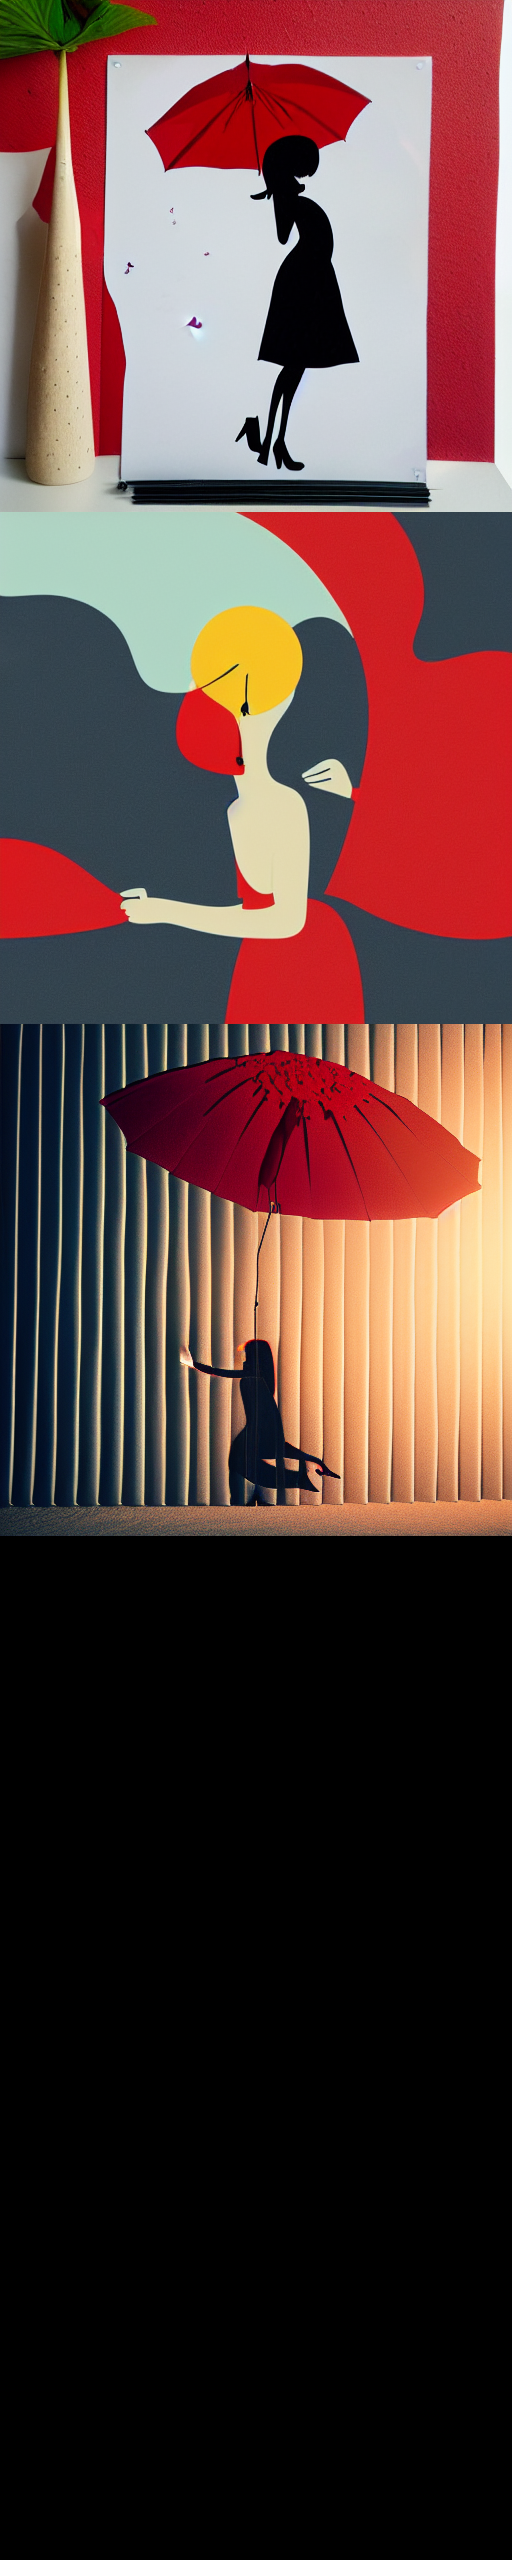

In [176]:
grid = image_grid(all_images, rows=len(concept_libraries))
grid